In [25]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp\_rx }| \text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }| \text{rssi} }$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

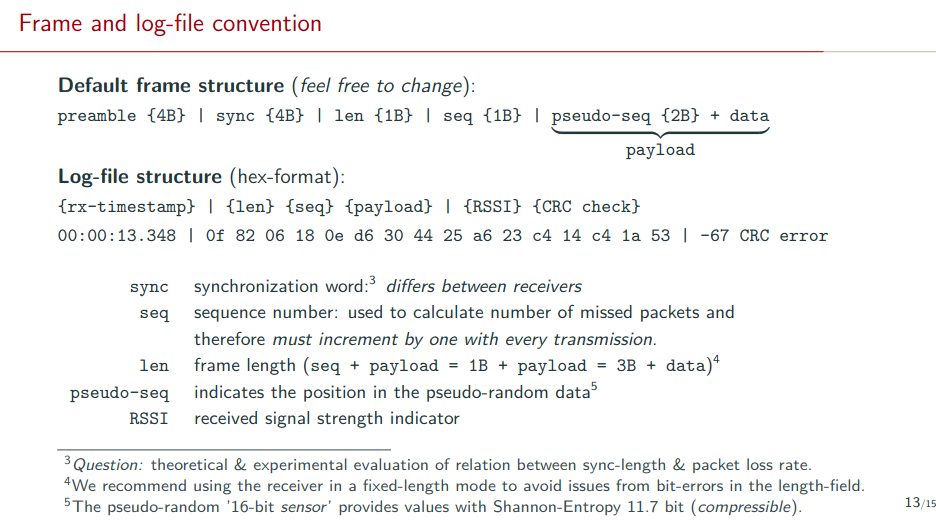

In [26]:
# define the file name
# filename = "data/dumpData_1"
filename = "/data/04_23/dumpData_256_test1"
# import file to jupyter notebook
df = readfile("./" + filename) #+ ".txt")
# check the imported data first 10 lines
df.head(10)

,index,time_rx,rssi,seq,payload
0,0,2025-04-23 12:20:12.152,-82,0,00 00 13 5d 1f 43 1b 45 25 6f 21 fe 0f 7e
1,1,2025-04-23 12:20:12.919,-78,3,00 24 19 e2 17 c2 25 4e 1d 4c 26 a4 31 bf
2,2,2025-04-23 12:20:13.173,-79,4,00 30 1c 08 23 fc 17 c2 22 1b 1c e4 25 de
3,3,2025-04-23 12:20:13.942,-80,7,00 54 25 a3 2f 9e 25 88 22 96 1e 88 20 eb
4,4,2025-04-23 12:20:14.195,-77,8,00 60 16 6d 12 10 22 59 2c 67 11 f6 1f a4
5,5,2025-04-23 12:20:14.452,-78,9,00 6c 12 ef 22 26 29 73 31 88 26 2d 1e 06
6,6,2025-04-23 12:20:14.962,-79,11,00 84 23 eb 12 4a 23 19 14 e7 29 81 1d cf
7,7,2025-04-23 12:20:15.218,-80,12,00 90 20 4f 20 cd 31 6b 1d d7 14 34 1f f0
8,8,2025-04-23 12:20:15.474,-81,13,00 9c 31 bc 2d 44 20 a6 12 42 21 f3 20 51
9,9,2025-04-23 12:20:15.981,-81,15,00 b4 1f b9 1d 5e 20 00 00 00 00 00 05 37


In [27]:
# delete packets of invalid length (aka. error in length field at variable receiver length config) (PAYLOADSIZE + 2B pesudo sequence number)
test = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
test.reset_index(inplace=True)

# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [28]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:01:04.853000, which is 64.853 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ received}$$
<br>*Achieved Data Rate*: The bit error rate is calculated based on the received data only. Missing packets do not affect the bit error rate, but are reflected in the achievable data rate.

## Statistics

In [29]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber = compute_ber(test, PACKET_LEN=NUM_16RND*2)
bit_reliability = (1-ber)*100
print(f"Bit error rate [%]: {(ber*100):.8f}\t\t(in received packets within pseudo sequence + payload) ")
if len(df) < 1:
    print("Data rate [bit/s]: More than one packet required for analysis.")
else:
    print(f"Data rate [bit/s]: {(len(df)*NUM_16RND*2/file_delay_s):.8f}\t\t(directly impacted by missed packets) ")

packet_loss = compute_packet_loss(df)
per = compute_packet_error_rate(df)
avg_rssi = compute_average_rssi(df)

print(f"Packet loss: {packet_loss*100:.2f}%")
print(f"Packet error rate: {per*100:.2f}%")
print(f"Average RSSI: {avg_rssi}")

The total number of packets transmitted by the tag is 255.
Bit error rate [%]: 6.25000000		(in received packets within pseudo sequence + payload) 
Data rate [bit/s]: 29.23534763		(directly impacted by missed packets) 
Packet loss: 38.04%
Packet error rate: 30.38%
Average RSSI: -78.84810126582279


Note: if individual packets have a high bit-error rate, it could be that the pseudo-sequence number was corrupted and the script could not identify the expected payload correctly.


Text(0.5, 0, 'Seq. Number')

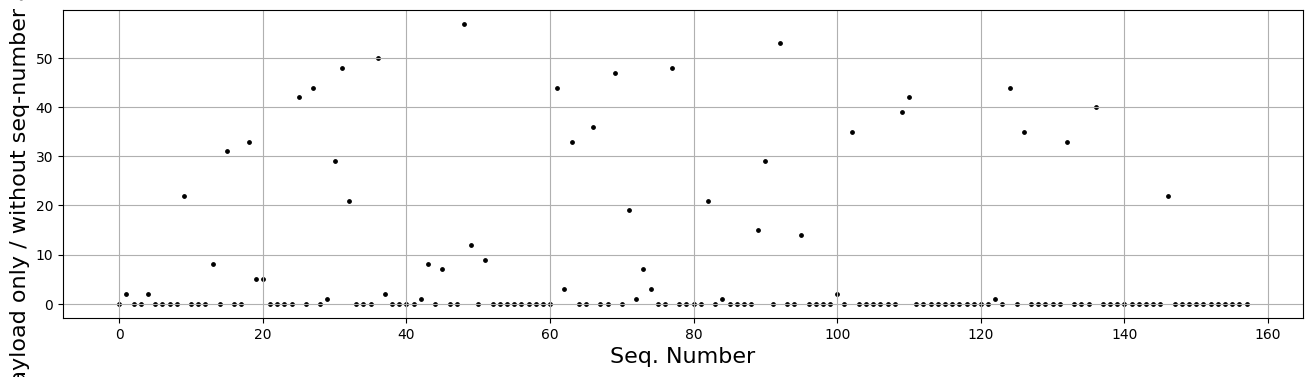

In [30]:
# BER for each packet
print("Note: if individual packets have a high bit-error rate, it could be that the pseudo-sequence number was corrupted and the script could not identify the expected payload correctly.")
plt.scatter(range(len(df)), [compute_ber_packet(row,PACKET_LEN=NUM_16RND*2)[0] for (_,row) in df.iterrows()], marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%] (payload only / without seq-number and pseudo-seq-number)', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [31]:
# record the distance
dis_carrier_tag = 1
dis_tag_rx = 4

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 16


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

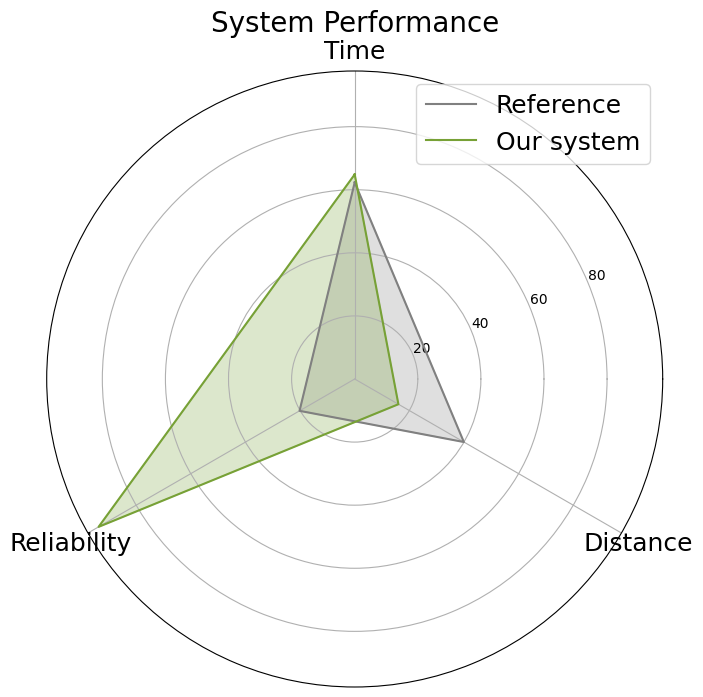

In [32]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)